## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using GRUs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
!pip install scikit-plot
!pip install portalocker

In [2]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc
import matplotlib.pyplot as plt

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [4]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [5]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [6]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [7]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [8]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [9]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [10]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [11]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y) - 1

In [12]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

In [14]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([256, 50]) torch.Size([256])


### Let us build our RNN model

In [15]:
embed_size = 50
hidden = 50
layers = 1
num_classes = len(labels)

In [16]:
len(vocab)

95811

In [17]:
class GRU_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)
        self.hidden = hidden
        self.layers = layers
        # Define the GRU layer - use PyTorch nn.GRU(), nn.GRU(), or nn.LSTM()
        self.GRU = nn.GRU(embed_size, hidden, layers, batch_first=True)
        # Define the output layer - output classifier layer using linear layer
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        # Forward pass through the GRU
        embeddings = self.embedding_layer(x)
        out, h = self.GRU(embeddings, torch.randn(layers, len(x), hidden))
        return self.fc(out[:,-1])

In [18]:
GRU_classifier = GRU_Model_1(embed_size, hidden, layers, num_classes)
GRU_classifier

GRU_Model_1(
  (embedding_layer): Embedding(95811, 50)
  (GRU): GRU(50, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=4, bias=True)
)

In [19]:
# Accuracy
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device)
            yi = yi.to(device=device)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)
        return float(num_correct)/num_total

In [20]:
def train(model, optimiser, epochs):
    model = model.to(device=device)
    train_cost = 0.
    val_cost = 0.

    for epoch in range(epochs):
      train_correct_num = 0.
      train_total = 0.
      train_cost_acum = 0.

      for x, y in train_loader:
        model.train()
        x = x.to(device=device)
        y = y.to(device=device)
        scores = model(x)

        cost = F.cross_entropy(input=scores, target=y)
        optimiser.zero_grad()
        cost.backward()
        optimiser.step()

      acc = accuracy(model, val_loader)
      print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')

In [24]:
epochs = 10
lr = 0.001
# instantiate model
GRU_model = GRU_Model_1(embed_size, hidden, layers, num_classes)
optimiser = torch.optim.Adam(GRU_model.parameters(), lr=lr)

In [25]:
train(GRU_model, optimiser=optimiser,  epochs=epochs)

Epoch: 0, costo: 0.5440247058868408, accuracy: 0.7805,
Epoch: 1, costo: 0.4324774444103241, accuracy: 0.86075,
Epoch: 2, costo: 0.2967015206813812, accuracy: 0.8805,
Epoch: 3, costo: 0.28222721815109253, accuracy: 0.8905,
Epoch: 4, costo: 0.2454736977815628, accuracy: 0.896,
Epoch: 5, costo: 0.21435831487178802, accuracy: 0.89775,
Epoch: 6, costo: 0.2059873640537262, accuracy: 0.898,
Epoch: 7, costo: 0.22896401584148407, accuracy: 0.9015833333333333,
Epoch: 8, costo: 0.1182352751493454, accuracy: 0.8994166666666666,
Epoch: 9, costo: 0.057908058166503906, accuracy: 0.8991666666666667,


In [26]:
print(f'{accuracy(GRU_model, test_loader):.4f}')

0.9043


In [44]:
def sample_text(model, loader):
  # Retrieving text examples from the test dataset
  x_test_text, y_test = [], []
  for y, x in test_dataset:
    x_test_text.append(x)
    y_test.append(y-1)
  # Selecting one text from test_dataset
  idx = np.random.randint(len(x_test_text))
  # Create list with indices from tokeniser
  x = [vocab(tokeniser(text)) for text in x_test_text[idx:idx+1]]
  x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]
  # Predicting
  preds = GRU_classifier(torch.tensor(x, dtype=torch.int32))
  preds = F.softmax(preds, dim=-1)
  return print('Prediction:', labels[preds.argmax()], 'Actual:', labels[y_test[idx]])

In [45]:
sample_text(GRU_model, test_loader)

Prediction: World Actual: World


In [29]:
def MakePredictions(model, loader):
    y_shuffled, y_preds = [], []
    for x, y in loader:
        preds = model(x)
        y_preds.append(preds)
        y_shuffled.append(y)
    gc.collect()
    y_preds, y_shuffled = torch.cat(y_preds), torch.cat(y_shuffled)
    return y_shuffled.detach().numpy(), F.softmax(y_preds, dim=-1).argmax(dim=-1).detach().numpy()

In [30]:
y_actual, y_preds = MakePredictions(GRU_model, test_loader)

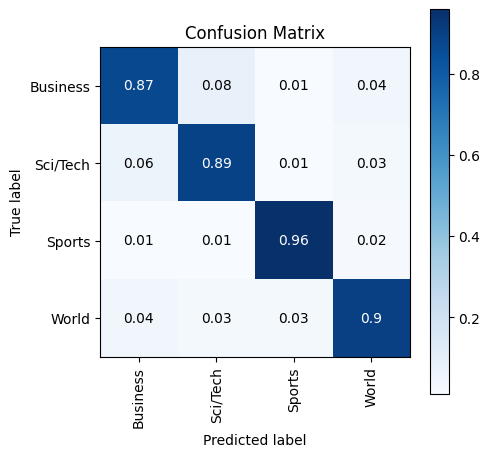

In [31]:
skplt.metrics.plot_confusion_matrix([labels[i] for i in y_actual], [labels[i] for i in y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5));
plt.xticks(rotation=90);